In [4]:
import os
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
import cv2
from tensorflow import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
import random
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation, MaxPool2D, Concatenate
from keras.optimizers import Adam
from keras import mixed_precision
from keras import backend as K
from keras.metrics import binary_crossentropy
import unets_repo

In [51]:
keras.backend.clear_session()

In [52]:
is_gpu_available = (len(tf.config.list_physical_devices('GPU')) > 0)
print(is_gpu_available)

#mixed_precision.set_global_policy('mixed_float16')
#os.environ["TF_ENABLE_AUTO_MIXED_PRECISION_GRAPH_REWRITE"] = "1"
#os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

True


In [5]:
fp1 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\validation_data"

In [6]:
batch_size = 6

---


In [7]:
def load_data(ids,suj_path,mask_path):
  suj_files = os.listdir(suj_path)
  mask_files = os.listdir(mask_path)
  X = []
  Y = []

  for i in ids:
    x = np.load(os.path.join(suj_path,suj_files[i]))
    y = np.load(os.path.join(mask_path,mask_files[i]))

    X.append(x)
    Y.append(y)

  return np.array(X), np.array(Y)

In [8]:
def batch_generator(suj_path, mask_path):
    suj_files = os.listdir(suj_path)
    indices = np.arange(len(suj_files))
    indices = np.random.permutation(indices)
    batch=[]
    while True:
            for i in indices:
                batch.append(i)
                if len(batch)==batch_size:
                    yield load_data(batch,suj_path,mask_path)
                    batch=[]

In [9]:
train_gen_ds = batch_generator(os.path.join(fp1,"sujetos"),os.path.join(fp1,"mascaras"))

val_gen_ds = batch_generator(os.path.join(fp2,"sujetos"),os.path.join(fp2,"mascaras"))

In [59]:
x,y = train_gen_ds.__next__()

In [60]:
print(x)

[[[ 1.60740341  1.20306311  0.74806368 ... -0.50978265 -0.65421709
   -0.72324334]
  [ 1.44542309  1.16154032  0.83589866 ... -0.80506874 -0.80844964
   -0.63504055]
  [ 1.32683958  1.21558934  1.1071492  ... -0.9789668  -0.80322896
   -0.47118557]
  ...
  [-0.2052309  -0.26817488 -0.14410159 ...  1.55836676  1.68051848
    1.98237978]
  [-0.20455127 -0.17889218 -0.0744365  ...  1.94120091  2.08164954
    2.14753382]
  [-0.14576727 -0.12699492 -0.06133364 ...  2.03909156  2.00414939
    1.88082379]]

 [[ 0.39501714  0.20672862  0.38350087 ...  1.33878211  1.2529797
    0.99538874]
  [ 0.53300018  0.62517328  1.08214131 ...  0.96234529  1.04268218
    0.98223372]
  [ 0.42866161  0.21034781  0.69989781 ...  0.33225511  0.49392875
    0.73474869]
  ...
  [-1.09265767 -1.07413646 -1.11321327 ... -1.22775844 -1.38151769
   -1.20887871]
  [-1.12919016 -1.12486675 -1.2296233  ... -0.94379501 -0.78740516
   -0.64250669]
  [-1.21964212 -1.29062766 -1.17565061 ... -0.08581743  0.34816176
    0.2

In [61]:
print(x.shape)
print(y.shape)
print(x.max(),x.min())
print(y.max(),y.min())

(6, 256, 256)
(6, 256, 256)
2.9459618606391174 -1.7224043297245188
1.2725944947328176 -0.23221983010072744


<function matplotlib.pyplot.show(close=None, block=None)>

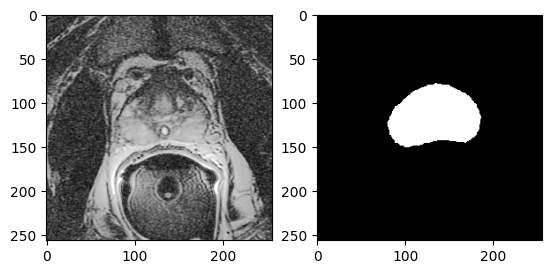

In [65]:
x,y = val_gen_ds.__next__()
image = x[0,:,:]
mask = y[0,:,:]
plt.subplot(1,2,1)
plt.imshow(image,cmap="gray")
plt.subplot(1,2,2)
plt.imshow(mask,cmap="gray")
plt.show

In [10]:
n_train_img = len(os.listdir(os.path.join(fp1,"sujetos"))) #si es para npy saco "img"
n_val_img = len(os.listdir(os.path.join(fp2,"sujetos")))
print(n_train_img,n_val_img)
spe = n_train_img//batch_size 
vspe = n_val_img//batch_size

3971 826


---


In [11]:

my_unet = unets_repo.UNet(input_size=(256,256,1), activation="selu", initializer="lecun_uniform")
#print(my_unet.summary())

In [12]:
def DiceBCE(targets, inputs, smooth=1e-6):    
       
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    intersection = K.sum(targets * inputs)
    
    return (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)

def Jaccard(targets, inputs, smooth=1e-6):
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    intersection = K.sum(K.abs(inputs * targets))
    union = K.sum(inputs) + K.sum(targets) - intersection
    
    return (intersection + smooth)/(union + smooth)

def DiceBCELoss(targets, inputs):    
    
    BCE =  K.mean(binary_crossentropy(targets, inputs))
    
    return BCE + 1 - DiceBCE(targets, inputs, smooth=1e-6)

def FocalLoss(targets, inputs, alpha=0.8, gamma=2):
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.mean(binary_crossentropy(targets, inputs))
    BCE_EXP = K.exp(-BCE)
    
    return alpha * K.pow((1-BCE_EXP), gamma) * BCE

In [ ]:
# from skimage.measure import label, regionprops
# from scipy.spatial.distance import directed_hausdorff

# # Calculate the Hausdorff distance between two binary images
# def hausdorff_distance(y_true, y_pred):
#     # Extract the connected components from the images
#     true_labels = label(y_true)
#     pred_labels = label(y_pred)
    
#     # Convert the images to sets of points
#     true_points = [region.coords for region in regionprops(true_labels)]
#     pred_points = [region.coords for region in regionprops(pred_labels)]
    
#     # Calculate the directed Hausdorff distance between the sets of points
#     distance = directed_hausdorff(true_points, pred_points)[0]
    
#     return distance

In [21]:
def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    initial_lr = 0.01
    decay = 0.95
    return initial_lr * decay ** epoch

In [13]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True,monitor="val_DiceBCE",mode="max"),
    tf.keras.callbacks.ModelCheckpoint(filepath='modelsh5/unet_model.{val_DiceBCE:.4f}_own_unet_selu_lecun.h5',save_best_only=True,save_weights_only=True,monitor="val_DiceBCE",mode="max"),
    #tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_DiceBCE', mode="max", factor=0.5,patience=5, min_lr=0.00001,min_delta=0.005)
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [14]:
#optimizer = tf.keras.mixed_precision.LossScaleOptimizer(Adam(learning_rate = 1e-3))
optimizer = Adam(learning_rate = 1e-2)

In [ ]:
#my_unet = keras.models.load_model("modelsh5/unet_model.00-0.0166-0.7759_base_focal_.h5",custom_objects={"DiceBCE":DiceBCE,"DiceBCELoss":DiceBCELoss,"FocalLoss":FocalLoss})

In [18]:
my_unet.load_weights("modelsh5/unet_model.0.8401_own_unet_selu_lecun.h5")

In [16]:
my_unet.compile(optimizer = optimizer, loss = DiceBCELoss, metrics = [DiceBCE,Jaccard])

In [17]:
history = my_unet.fit(train_gen_ds,
                    verbose=1, 
                    steps_per_epoch=spe,
                    epochs=100,
                    validation_data=val_gen_ds, 
                    validation_steps=vspe,
                    callbacks=my_callbacks)

Epoch 1/100
661/661 [==============================] - 415s 609ms/step - loss: 0.0743 - DiceBCE: 0.9417 - Jaccard: 0.8954 - val_loss: 0.2972 - val_DiceBCE: 0.8137 - val_Jaccard: 0.7035 - lr: 0.0100
Epoch 2/100
661/661 [==============================] - 395s 597ms/step - loss: 0.0697 - DiceBCE: 0.9454 - Jaccard: 0.9004 - val_loss: 0.2650 - val_DiceBCE: 0.8132 - val_Jaccard: 0.7167 - lr: 0.0100
Epoch 3/100
661/661 [==============================] - 320s 484ms/step - loss: 0.0703 - DiceBCE: 0.9450 - Jaccard: 0.8995 - val_loss: 0.2642 - val_DiceBCE: 0.8229 - val_Jaccard: 0.7226 - lr: 0.0100
Epoch 4/100
661/661 [==============================] - 279s 423ms/step - loss: 0.0679 - DiceBCE: 0.9463 - Jaccard: 0.9026 - val_loss: 0.3389 - val_DiceBCE: 0.7913 - val_Jaccard: 0.6726 - lr: 0.0100
Epoch 5/100
661/661 [==============================] - 260s 394ms/step - loss: 0.0635 - DiceBCE: 0.9496 - Jaccard: 0.9075 - val_loss: 0.2686 - val_DiceBCE: 0.8088 - val_Jaccard: 0.7114 - lr: 0.0100
Epoch 6/10

In [76]:
my_unet.save("modelsh5/unet_model.0.8459_new_unet_selu_lecun.h5")

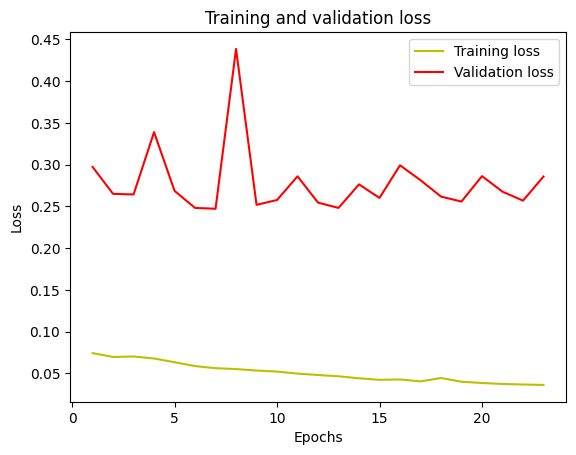

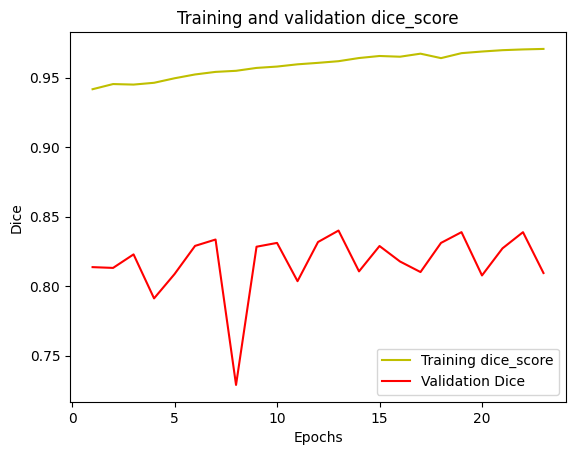

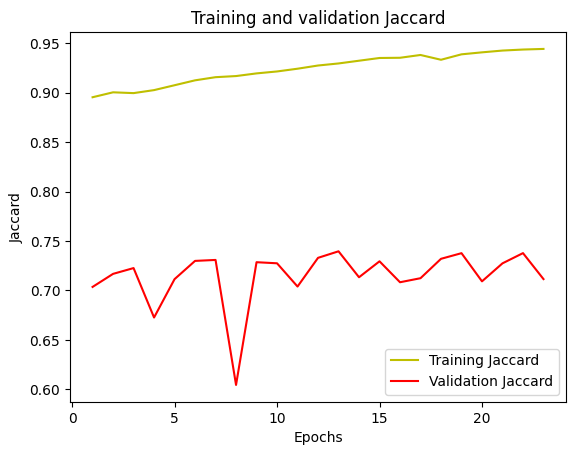

In [19]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['DiceBCE']
val_acc = history.history['val_DiceBCE']

plt.plot(epochs, acc, 'y', label='Training dice_score')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation dice_score')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

acc2 = history.history['Jaccard']
val_acc2 = history.history['val_Jaccard']

plt.plot(epochs, acc2, 'y', label='Training Jaccard')
plt.plot(epochs, val_acc2, 'r', label='Validation Jaccard')
plt.title('Training and validation Jaccard')
plt.xlabel('Epochs')
plt.ylabel('Jaccard')
plt.legend()
plt.show()

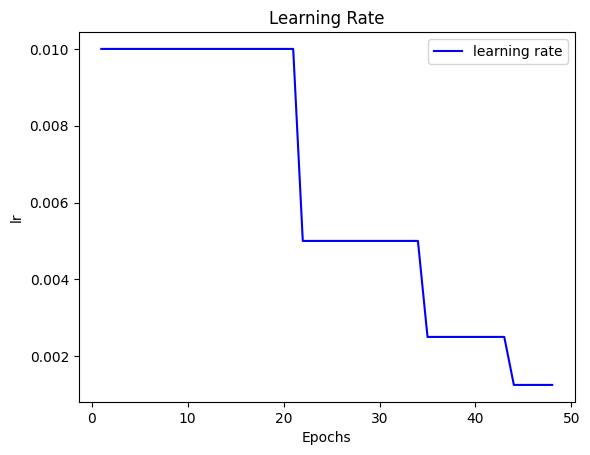

In [78]:
lrr = history.history['lr']

plt.plot(epochs, lrr, 'b', label='learning rate')
plt.title('Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('lr')
plt.legend()
plt.show()

1/1 [==============================] - 0s 21ms/step
Mean IoU = 1.0


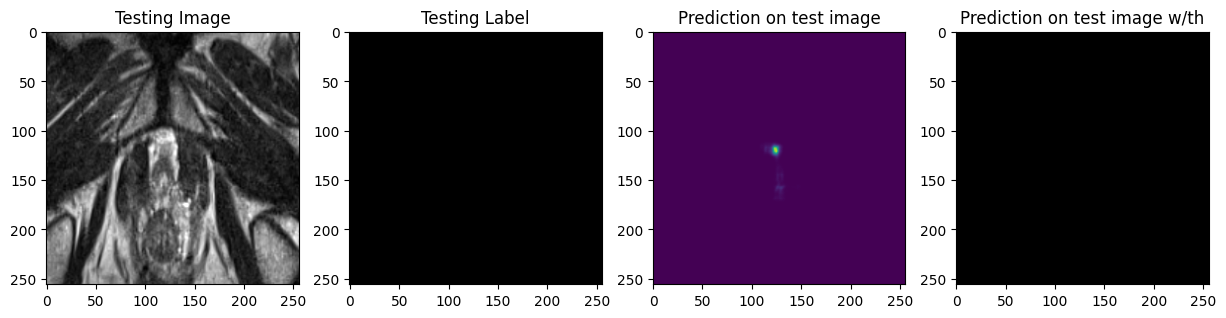

In [51]:
test_image_batch, test_mask_batch = val_gen_ds.__next__()
test_img_number = random.randint(0, len(test_image_batch)-1)
test_img = test_image_batch[test_img_number]
ground_truth=test_mask_batch[test_img_number]
test_img_norm=test_img[:,:]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (my_unet.predict(test_img_input))
predicted_img_th = prediction[0,:,:,0]>0.5

IOU_keras = MeanIoU(num_classes=2)  
IOU_keras.update_state(ground_truth, predicted_img_th)
print("Mean IoU =", IOU_keras.result().numpy())

plt.figure(figsize=(15, 10))
plt.subplot(241)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(242)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='gray')
plt.subplot(243)
plt.title('Prediction on test image')
plt.imshow(prediction[0,:,:,0])
plt.subplot(244)
plt.title('Prediction on test image w/th')
plt.imshow(predicted_img_th, cmap='gray')
plt.show()

In [58]:
with open('history_base_dice_selu_lecun.txt', 'w') as f:
    print(history.history, file=f)

In [47]:
my_unet.layers[8]

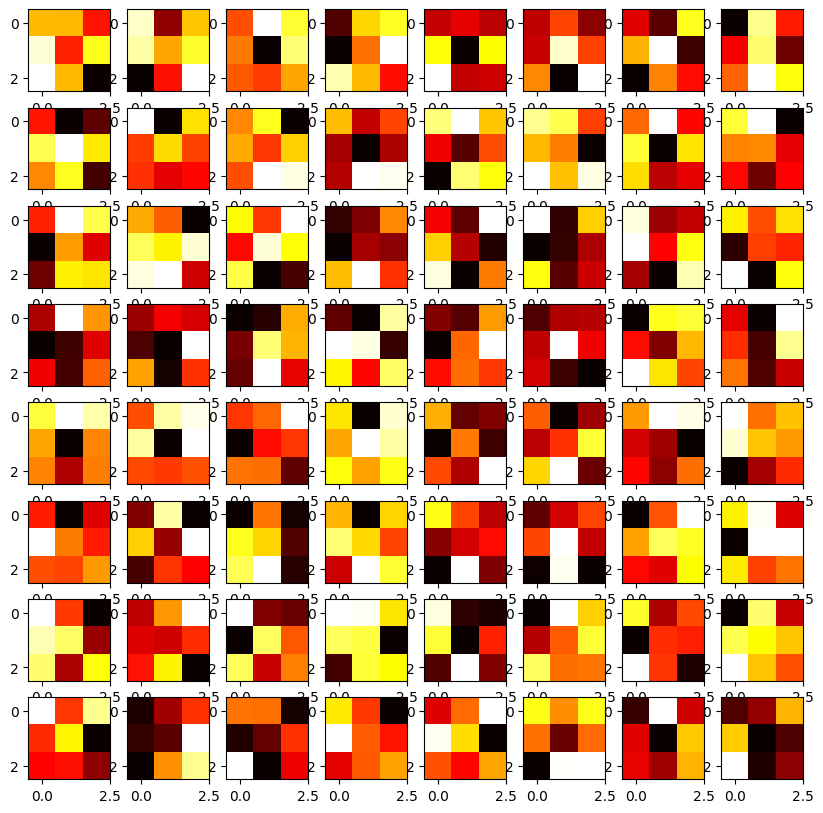

In [49]:
plt.figure(figsize=(10,10))
for i in range(64):
    filter = my_unet.layers[8].get_weights()[0][:,:,0,i]
    plt.subplot(8,8,i+1)
    plt.imshow(filter,cmap="hot")
plt.show()